<a href="https://colab.research.google.com/github/Jiablero/notebooks/blob/master/stepik_ml_contest_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

In [0]:
# results_example = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_example.csv')
submissions = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
events = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')


In [0]:
# полные варианты таблиц из https://stepik.org/lesson/222124/step/3?unit=195045
submissions_full = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
events_full = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')

In [0]:
# первоначальный вариант обработки данных
def process_users_data(submissions, events):
  score_by_user = events[events.action == 'passed'].groupby('user_id').agg({'action': 'count'}).rename({'action': 'score'}, axis = 1).reset_index()
  submissions = pd.get_dummies(submissions)
  attempts_by_user = submissions.groupby('user_id').agg({'submission_status_correct': 'sum', 'submission_status_wrong': 'sum'}) \
  .rename({'submission_status_correct': 'correct', 'submission_status_wrong': 'wrong'}, axis = 1).reset_index()
  user_scores = score_by_user.merge(attempts_by_user, how='inner')
  return user_scores

In [0]:
user_scores = process_users_data(submissions, events)

In [0]:
user_scores['passed'] = user_scores.score.map(lambda x: 1 if x >= 40 else 0)

In [49]:
user_scores

,user_id,score,correct,wrong,passed
0,12,9,1,0,0
1,13,70,29,36,1
2,15,1,10,30,0
3,21,68,24,103,1
4,35,30,7,35,0
...,...,...,...,...,...
2781,26775,103,46,160,1
2782,26780,43,16,7,1
2783,26785,4,3,1,0
2784,26796,4,2,3,0


In [0]:
user_scores_full = process_users_data(submissions_full, events_full)

In [0]:
# Рефакторинг фичаинжинеринга !!!1

In [0]:
# добываем статистику степов из submissions
def process_steps_data(submissions):
  steps_stat = pd.get_dummies(submissions).groupby('step_id') \
    .agg({'submission_status_correct': 'sum', 'submission_status_wrong': 'sum'}) \
    .reset_index()
  
  # доля правильных ответов в сумме отправленных
  steps_stat['corrrate'] = steps_stat.submission_status_correct / (steps_stat.submission_status_correct + steps_stat.submission_status_wrong)

  # популярность степов в % по отношению к самому популярному
  steps_stat['popularity'] = steps_stat.submission_status_correct + steps_stat.submission_status_wrong
  steps_stat.popularity = steps_stat.popularity / steps_stat.popularity.max()
  
  return steps_stat

In [0]:
# добываем статистику степов из events
def process_steps_data_ev(events):
  steps_stat_ev = pd.get_dummies(events).groupby('step_id') \
  .agg({'action_discovered': 'sum', 
        'action_passed': 'sum', 
        'action_started_attempt': 'sum', 
        'action_viewed': 'sum'}).reset_index()

  # доля пройденных степов по отношению к начатым
  steps_stat_ev['corrrate_ev'] = steps_stat_ev.action_passed / steps_stat_ev.action_started_attempt
  
  # популярность степов в % по отношению к самому популярному
  steps_stat_ev['popularity_ev'] = steps_stat_ev.action_viewed / steps_stat_ev.action_viewed.max()
  
  return steps_stat_ev

In [0]:
steps_stat = process_steps_data(submissions)

In [0]:
steps_stat_ev = process_steps_data_ev(events)

In [0]:
steps_stat_merged = steps_stat.merge(steps_stat_ev, how='inner')

In [227]:
# время от времени стоит задавать себе вопрос: а не хуйню ли я делаю?
steps_stat_merged[['corrrate', 'corrrate_ev', 'popularity', 'popularity_ev']].corr()

,corrrate,corrrate_ev,popularity,popularity_ev
corrrate,1.000000,0.323288,0.169948,0.256477
corrrate_ev,0.323288,1.000000,0.694321,0.712206
popularity,0.169948,0.694321,1.000000,0.963518
popularity_ev,0.256477,0.712206,0.963518,1.000000


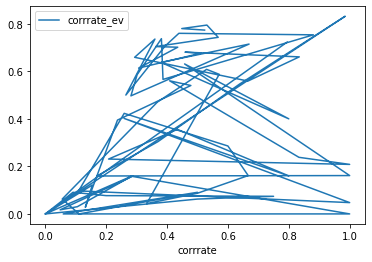

In [229]:
# хуйню...
steps_stat_merged.plot('corrrate', 'corrrate_ev')